# Load Packages

In [1]:
from matplotlib import pyplot as plt 
import scanpy as sc
import anndata as ad
import celltypist
from celltypist import models
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import seaborn as sns

# Read in Samples

In [2]:
sample1 = sc.read_10x_mtx('samples/case1yf/')
sample2 = sc.read_10x_mtx('samples/case1zy/')
sample3 = sc.read_10x_mtx('samples/case2yf/')
sample4 = sc.read_10x_mtx('samples/case2zc/')
sample5 = sc.read_10x_mtx('samples/case2zy/')
sample6 = sc.read_10x_mtx('samples/case3yf/')
sample7 = sc.read_10x_mtx('samples/case3zy/')
sample8 = sc.read_10x_mtx('samples/case4zy/')

# Preprocessing
**Goals:** QC for each sample and doublet detection

**Figures:**
1. Number of unique genes detected per barcode
2. Total number of molecules per barcode
3. % reads that map to mitochondrial genome
4. Joint visualization of above metrics for each sample
5. Results from doublet detection algorithm
6. Table with number of cells and genes present before and after filtering

**Discussion:**
1. What filtering thresholds did you choose and how did you decide on them?
    * Cells were filtered if they had less than 200 genes and more than 20% of their genes were mitochondrial genes. These thresholds were outlined in the methods section of the reference paper. In order to replicate their results as well as possible, I mimicked their thresholds. Genes were filtered out if they appeared in less than 3 cells. I chose to filter out genes since this is the standard in scRNA-Seq studies that implement scanpy. The reference study didn't use scanpy and didn't filter their genes based on low relative frequency.
2. How many cells and genes are present before and after filtering?
    * For all samples, there were original 33,538 genes present before filtering. After filtering this changed dramatically: sample 1 has 21,640; sample 2 has 21,572; sample 3 has 21,715; sample 4 has 18,492; sample 5 has 22,523; sample 6 has 22,668; sample 7 has 22,970; and sample 8 has 16,470. Across samples, the number of cells before and after filtering was variable. Sample 1 had 21,640 cells before and 8,160 cells after filtering. Sample 2 had 13,685 cells before and 8,497 cells after. Sample 3 had 11,786 cells before and 11,348 cells after. Sample 4 had 6,606 cells before and 6,398 cells after. Sample 5 had 9,406 cells before and 9,100 after. Sample 6 had 9,379 cells before and 8,176 cells after. Sample 7 had 8,837 cells before and 7,809 cells after. Sample 8 had 2,024 cells before and 1,406 cells after.
3. Look in literature, what are some potential strategies to set thresholds that don't rely on visual inspection of plots?
    * A standard implementation is just using a fixed threshold value for all samples. In on study, the researchers filtered out cells with less than 10,000 reads and cells with a mitochondrial gene proportion greater than 0.2 ([Tao et al. 2022](https://pmc.ncbi.nlm.nih.gov/articles/PMC8872562/#:~:text=Cells%20with%20read%20numbers%20less%20than%2010%2C000,expression%20level%20and%20dispersion%20for%20each%20gene.)). Additionally, you could use a function that identifies outliers in the data without visual inspection, such as isOutlier() function implemented by Bioconductor ([Bioconductor](https://bioconductor.org/packages/release/bioc/vignettes/scuttle/inst/doc/qc.html#:~:text=33%5D%20%22total%22-,3%20Identifying%20outliers%20on%20QC%20metrics,3%20MADs%20from%20the%20median.&text=Note%20that%20the%20attributes%20of,if%20this%20is%20of%20interest.&text=Advanced%20users%20can%20set%20batch,MADs%20due%20to%20batch%20effects.)).

In [3]:
# create dictionary of samples
samples = {
    "sample1": sample1,
    "sample2": sample2,
    "sample3": sample3,
    "sample4": sample4, 
    "sample5": sample5,
    "sample6": sample6,
    "sample7": sample7,
    "sample8": sample8}

In [4]:
# figure out number of genes and cells before filtering
for sample_name, sample_data in samples.items():
    print(sample_name, " Number of genes: ", sample_data.var.shape[0])
    print(sample_name, " Number of cells: ", sample_data.obs.shape[0])

sample1  Number of genes:  33538
sample1  Number of cells:  21560
sample2  Number of genes:  33538
sample2  Number of cells:  13685
sample3  Number of genes:  33538
sample3  Number of cells:  11786
sample4  Number of genes:  33538
sample4  Number of cells:  6606
sample5  Number of genes:  33538
sample5  Number of cells:  9406
sample6  Number of genes:  33538
sample6  Number of cells:  9379
sample7  Number of genes:  33538
sample7  Number of cells:  8837
sample8  Number of genes:  33538
sample8  Number of cells:  2024


In [5]:
# identify mitochondrial, ribosomal, and hemoglobin genes for each sample 
for name, sample in samples.items():
    sample.var["mt"] = sample.var_names.str.startswith("MT-")
    sample.var["ribo"] = sample.var_names.str.startswith(("RPS", "RPL"))
    sample.var["hb"] = sample.var_names.str.contains("^HB[^(P)]")

# calculate QC metrics
for name, sample in samples.items():
    sc.pp.calculate_qc_metrics(
    sample, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)


## Figures 1-3

... storing 'feature_types' as categorical


sample1


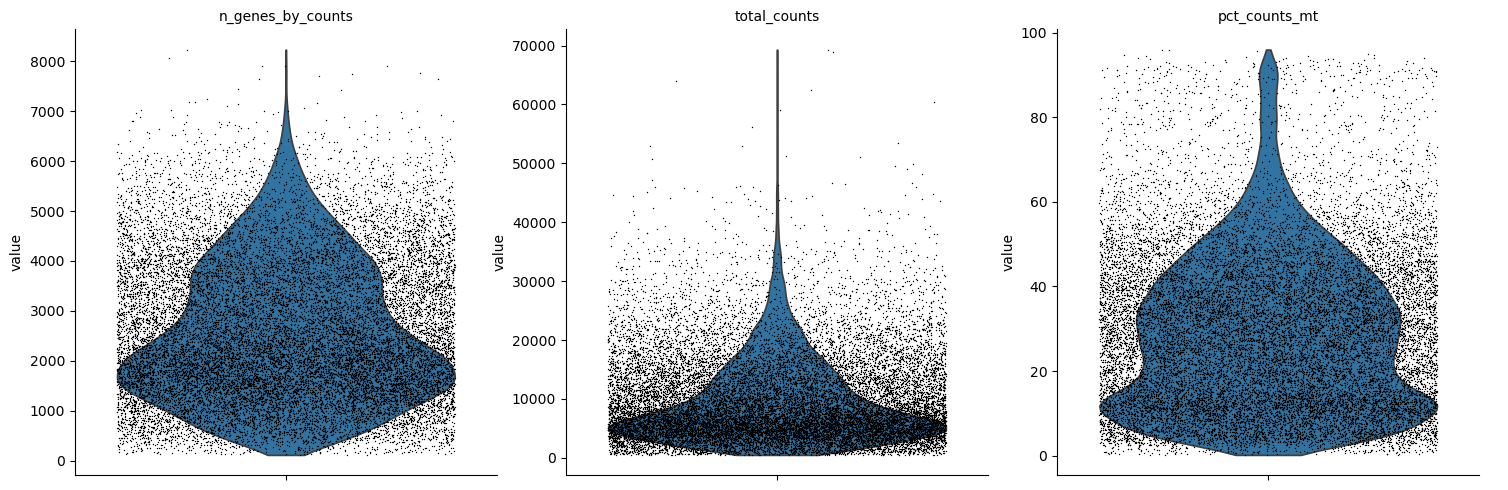

... storing 'feature_types' as categorical


sample2


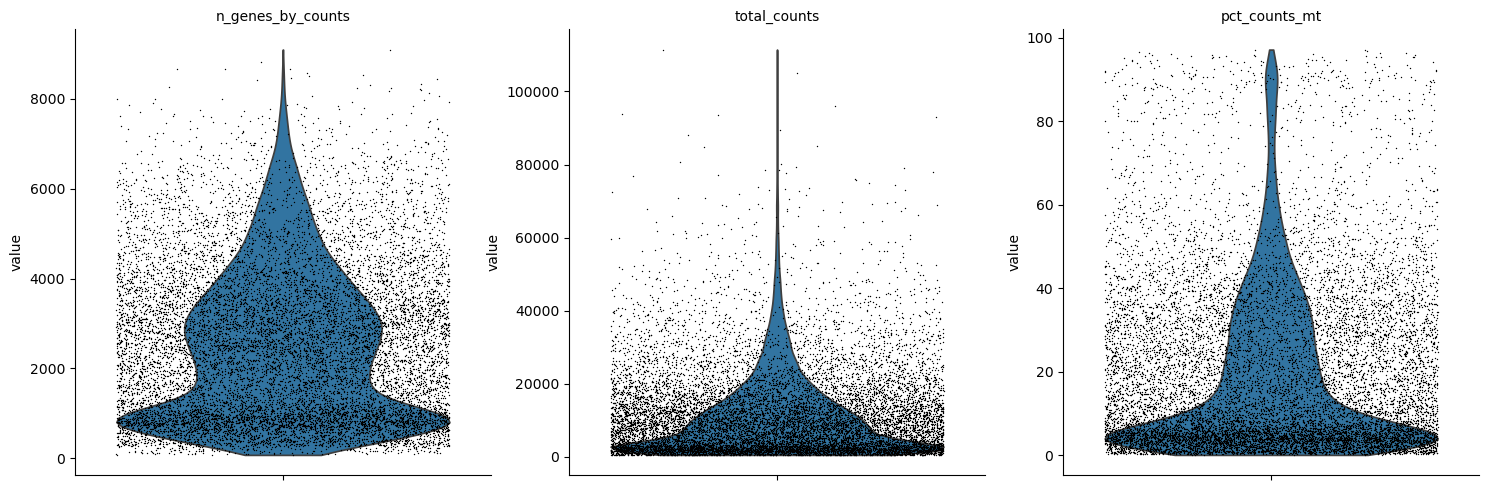

... storing 'feature_types' as categorical


sample3


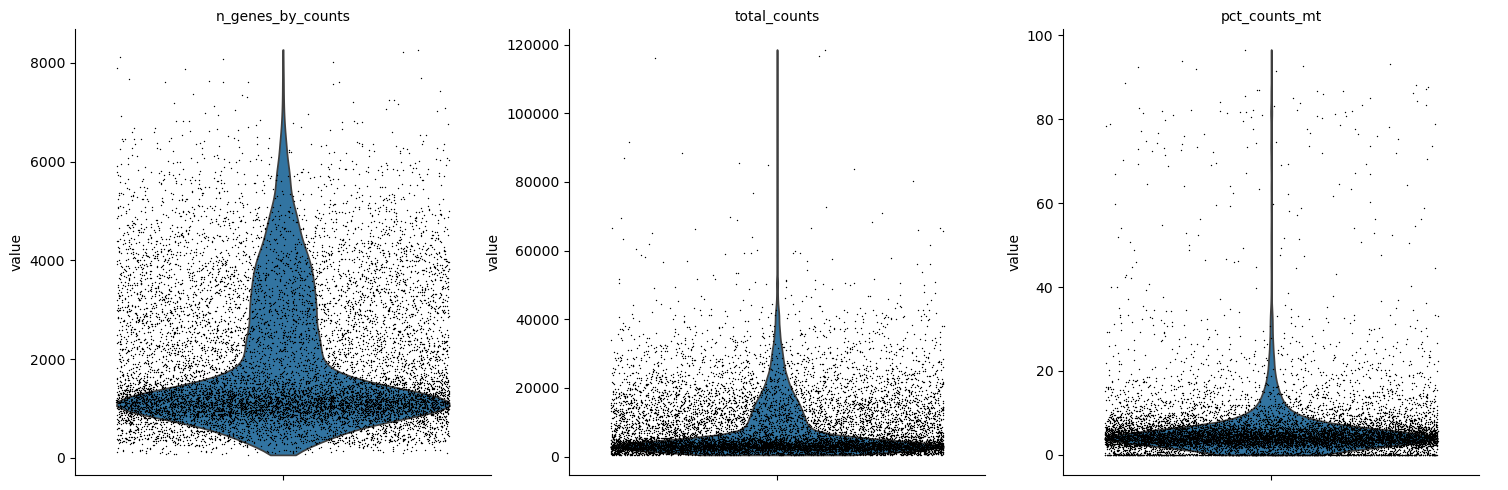

... storing 'feature_types' as categorical


sample4


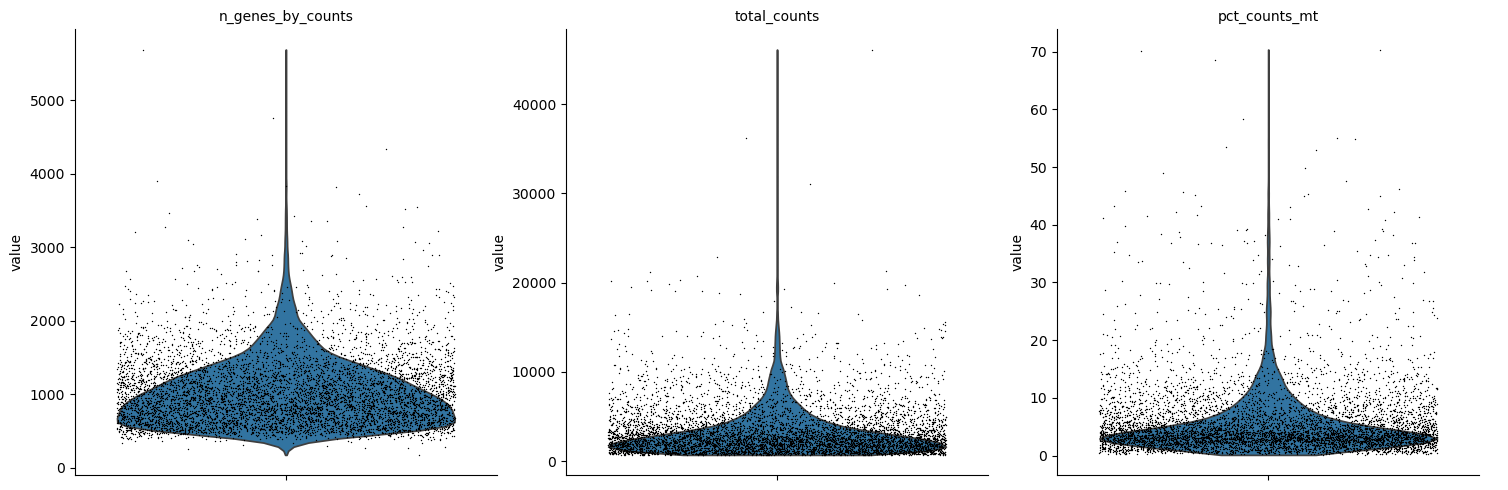

... storing 'feature_types' as categorical


sample5


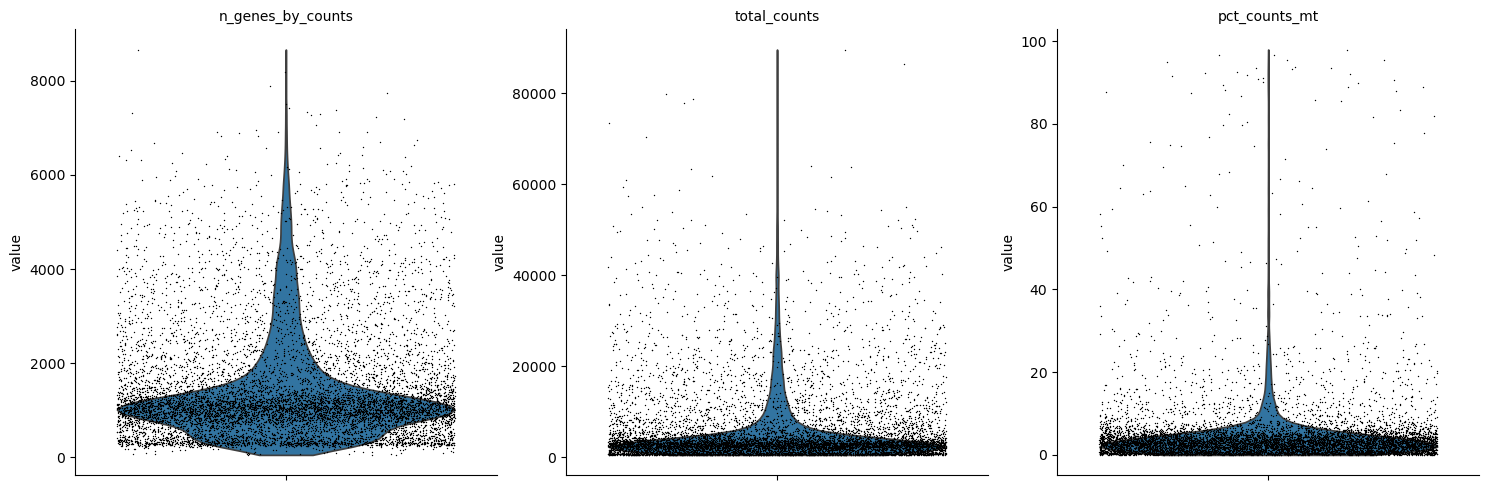

... storing 'feature_types' as categorical


sample6


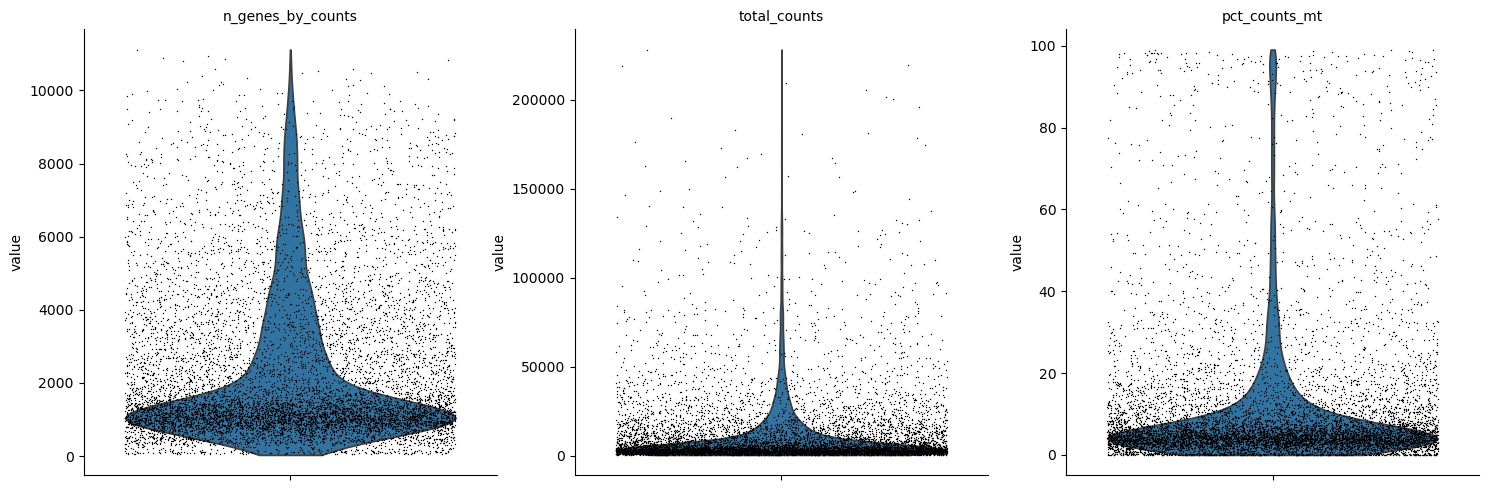

... storing 'feature_types' as categorical


sample7


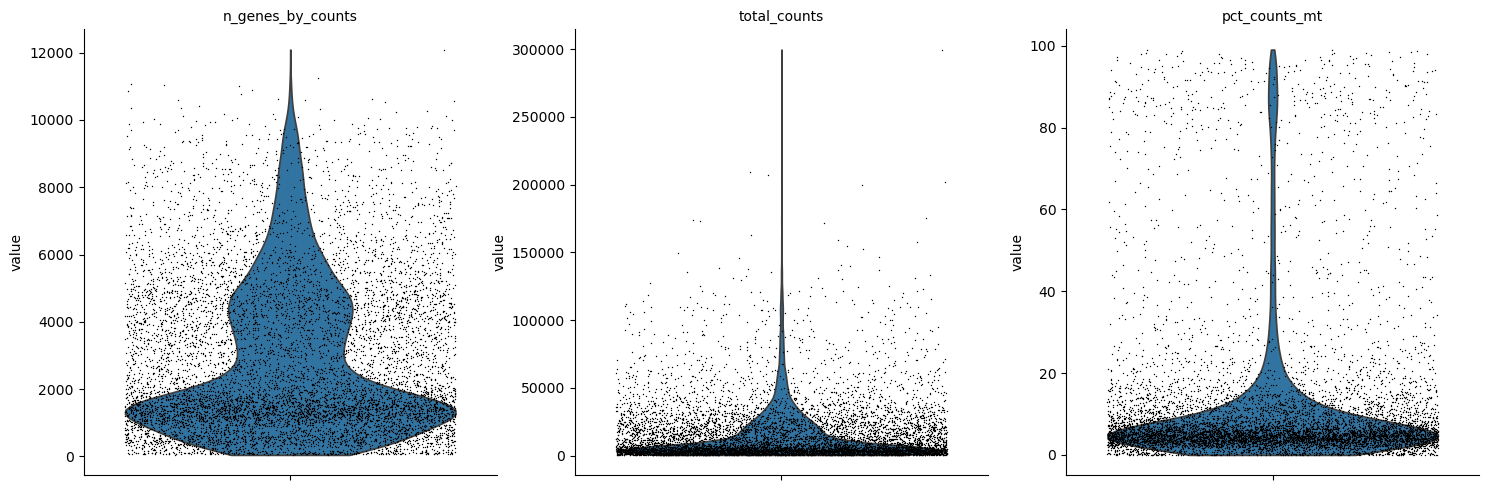

... storing 'feature_types' as categorical


sample8


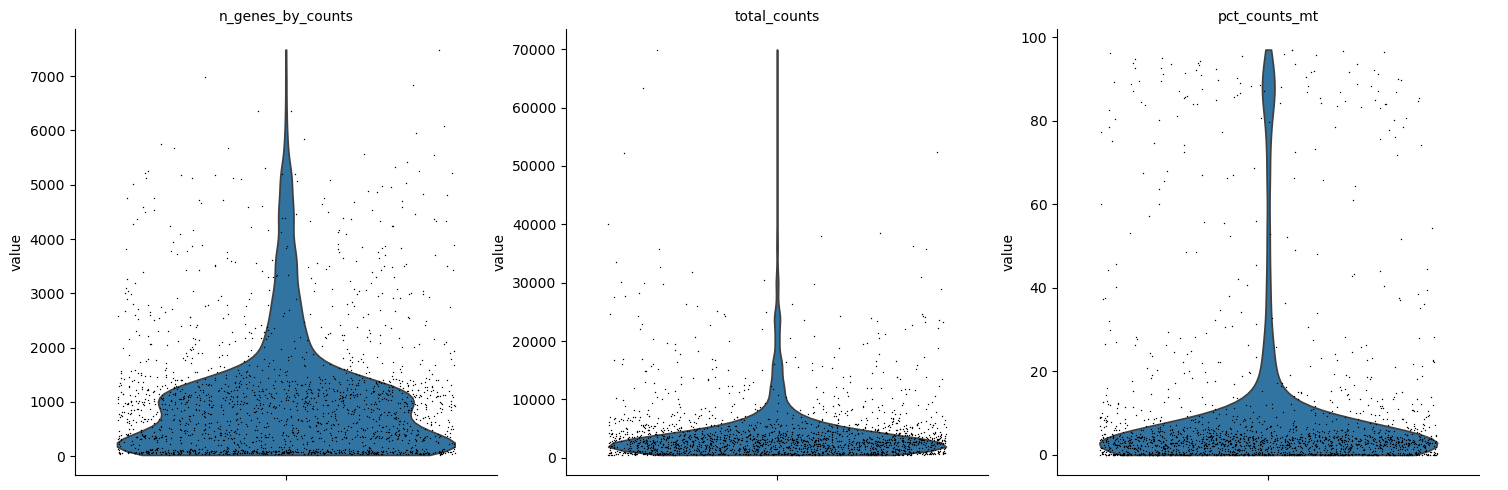

In [6]:
# QC plots for number unique genes per barcode, total number of molecules per barcode, and % reads that map to mitochondrial genome
for name, sample in samples.items():
    print(name)
    sc.pl.violin(
    sample,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## Figure 4

sample1


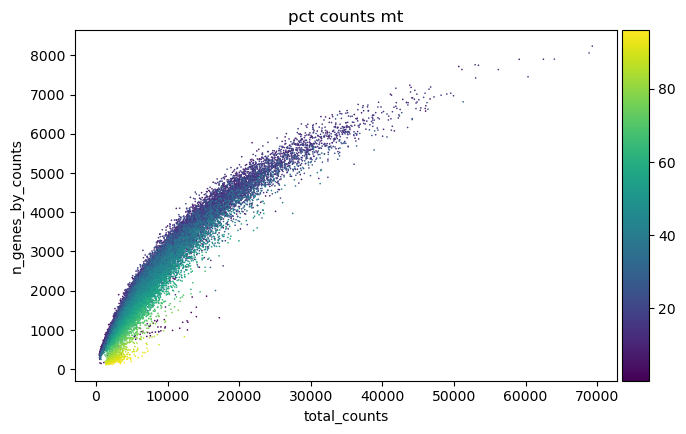

sample2


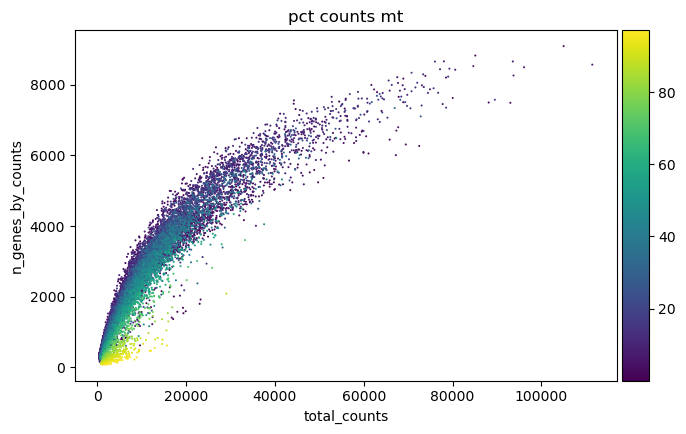

sample3


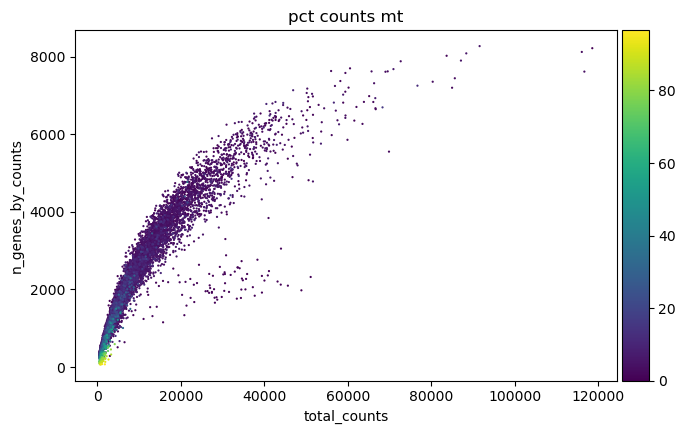

sample4


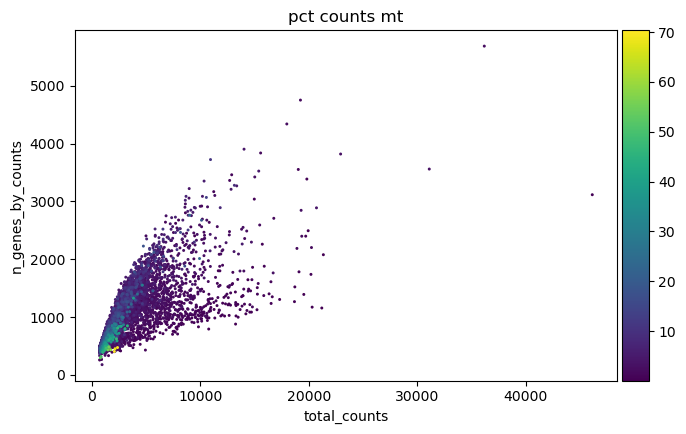

sample5


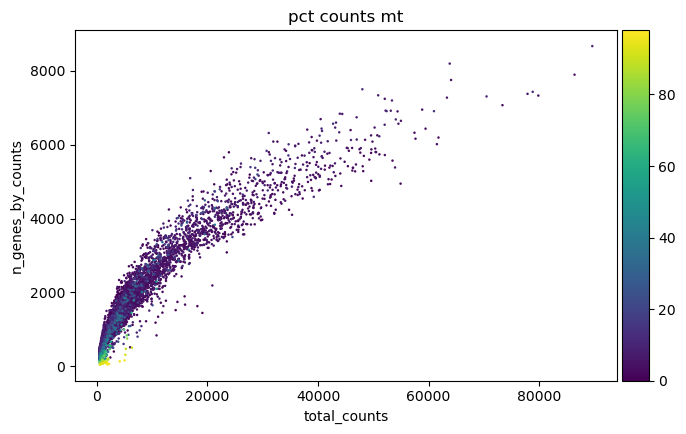

sample6


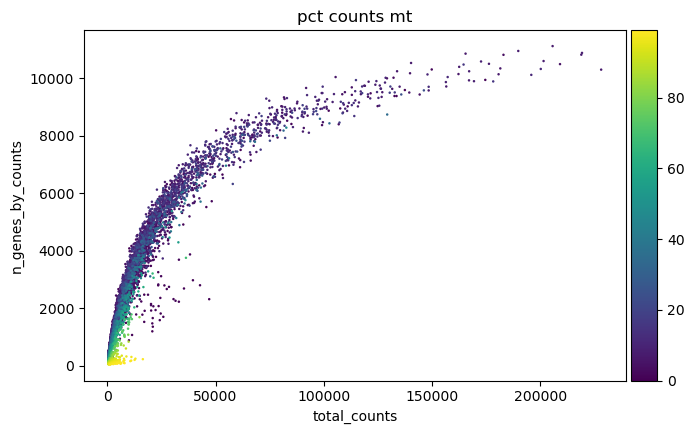

sample7


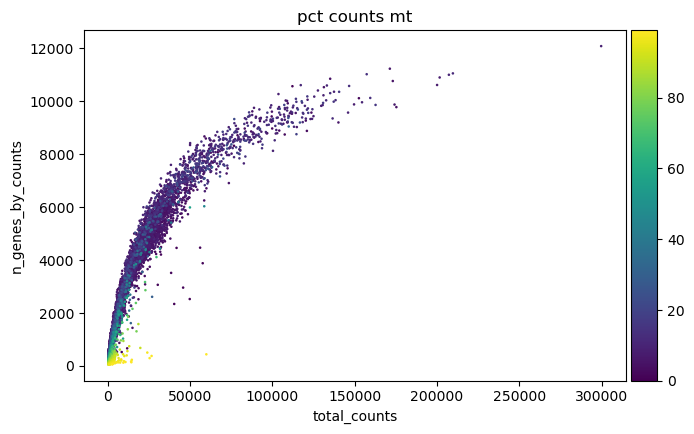

sample8


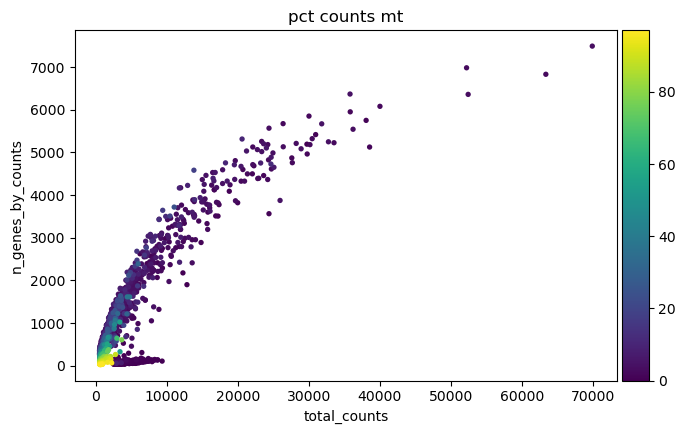

In [7]:
# QC plots for joint visualization of above metrics
for name, sample in samples.items():
    print(name)
    sc.pl.scatter(sample, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Filtering & Doublet Detection

Filtering based on thresholds found in paper:
*  less than 200 genes per cell
*  more than 20% mitochondrial reads per cell

Additionally, filtering out barcodes with less than 3 cells

In [8]:
# filtering
for name, sample in samples.items():
    sc.pp.filter_cells(sample, min_genes=200)
    sc.pp.filter_genes(sample, min_cells=3)
    samples[name] = sample[sample.obs['pct_counts_mt'] < 20, :]

In [9]:
# doublet finding
for name, sample in samples.items():
    sc.pp.scrublet(sample)

In [10]:
for sample_name, sample_data in samples.items():
    print(sample_name, " Number of genes post-scrublet: ", sample_data.var.shape[0])
    print(sample_name, " Number of cells post-scrublet: ", sample_data.obs.shape[0])

sample1  Number of genes post-scrublet:  21640
sample1  Number of cells post-scrublet:  8160
sample2  Number of genes post-scrublet:  21572
sample2  Number of cells post-scrublet:  8497
sample3  Number of genes post-scrublet:  21715
sample3  Number of cells post-scrublet:  11348
sample4  Number of genes post-scrublet:  18492
sample4  Number of cells post-scrublet:  6398
sample5  Number of genes post-scrublet:  22523
sample5  Number of cells post-scrublet:  9100
sample6  Number of genes post-scrublet:  22668
sample6  Number of cells post-scrublet:  8176
sample7  Number of genes post-scrublet:  22970
sample7  Number of cells post-scrublet:  7809
sample8  Number of genes post-scrublet:  16470
sample8  Number of cells post-scrublet:  1406


## Figure 6: Table of Pre-Post Filtering Gene and Cell Counts

| Sample | # of Cells Before | # of Cells After | # of Genes Before | # of Genes After |
| ---------- | -------- | -------- |-------- |-------- |
| Sample 1 | 21560 |   8160   | 33538 | 21640 |
| Sample 2 | 13685 |     8497     |  33538 | 21572 |
| Sample 3 | 11786 | 11348 | 33538 | 21715 |
| Sample 4 | 6606 | 6398 | 33538 | 18492 |
| Sample 5 | 9406 | 9100 | 33538 | 22523 |
| Sample 6 | 9379 | 8176 | 33538 | 22668 |
| Sample 7 | 8837 | 7809 | 33538 | 22970 |
| Sample 8 | 2024 | 1406 | 33538 | 16470 |     


# Count Normalization

**Discussion:**
1. Choose a method to normalize scRNA-Seq data and ensure that you explain the exact normalization procedure.
    * Since scRNA-Seq data is variable due to varying sequencing depths for the cells across samples, we must normalize the raw counts. Median normalization is a standard technique that scales the counts so that each cell has the same median count value. Following normalization with a log transformation stabilizes the variance so that we can extract meaningful insights into differential expression.

In [11]:
# combine samples
adata = ad.concat([samples["sample1"], samples["sample2"], samples["sample3"], samples["sample4"], samples["sample5"], samples["sample6"], samples["sample7"], samples["sample8"]], 
join='outer', label="sample", keys=["sample1", "sample2", "sample3", "sample4", "sample5", "sample6", "sample7", "sample8"])

In [12]:
# copy over the counts matrix
adata.layers["counts"] = adata.X.copy()
# median scaling normalization
sc.pp.normalize_total(adata)
# log(x+1) transformation
sc.pp.log1p(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 60894 × 25870
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample'
    uns: 'log1p'
    layers: 'counts'

# Feature Selection

**Goals:** choose appropriate method for feature selection and number of highly variable features for downstream analysis

**Figures:**
1. Plot of highly variable features by chosen metric

**Discussion:**
1. Explain method used to determine highly variable features and report how many variable features you chose to use for downstream dimensional reduction
    * To determine highly variable features, I followed the methods in the original paper. The researchers selected 2000 features, so I selected the top 2000 genes. Choosing the top 2000 genes allows us to focus in on genes that have significant variation across samples. I implemented the batch_key parameter to reduce noise that might be present due to batch effects.
2. Brief statement on how many genes meet threshold to be considered highly variable and how many are not
    * Only 2000 genes met the threshold to be considered highly variable, marking 23,870 genes of the detected genes as not highly variable.

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

In [15]:
adata

AnnData object with n_obs × n_vars = 60894 × 25870
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

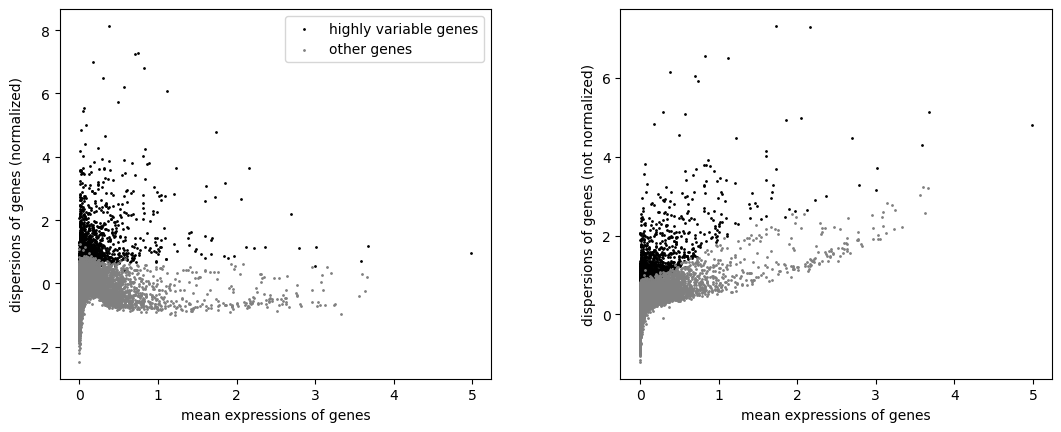

In [16]:
sc.pl.highly_variable_genes(adata)

# PCA

**Figures:**
1. Plot that justifies number of PCs used for downstream analysis

**Discussion:**
1. Justify choice in writing and discuss plot
    * For downstream analysis, I will choose to filter based on the first 30 principal components. This figure displays the log transformed variance the first 50 PCs capture. The paper methods' states that the researchers used the first 30 PCs for downstream analysis. I also chose 30 to mimick to results, but based on the figure below 30 PCs is a good choice since there appears to be consistent leveling off between 28 and 37 PCs.

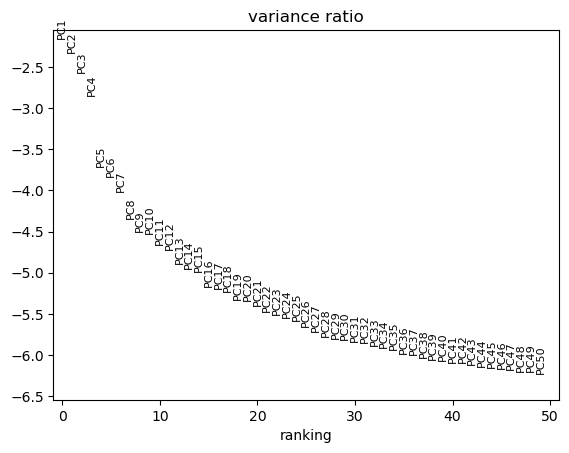

In [17]:
# run PCA
sc.tl.pca(adata)
# visualize PCs
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

# Clustering and Visualization

**Goals:** decide on appropriate clustering method and create visualization (UMAP/T-SNE), choose appropriate resolution for clustering algorithm

**Figures:**
1. Visualizing clustering results of cells with labels that identify different clusters
2. Visualizing clustering results of cells with labels that identify samples cells came from

**Discussion:**
1. Explain results up until now, inlcuding: how many cells come from each sample? how many total cells in entire dataset? what clustering resolution did you use?
    * After filtering, there is a combined total of 60,894 cells in the dataset. In order of most to least number of cells, here are the samples and their cell counts: sample 3 has 11,348; sample 5 has 9,100; sample 2 has 8,497; sample 6 has 8,176; sample 1 has 8,160; sample 7 has 7,809; sample 4 has 6,398; and sample 8 has 1,406 cells. For UMAP clustering, I implemented the Leiden algroithm with a resolution of 0.8. This resolution value came straight from the paper's methods section.
2. Use second plot and remark on whether you will need to perform integration
    * Based on the second plot, I will perform integration. Here we see that sample 4 is very distinctly removed from the other samples. Therefore, there might be some batch effects in sample 4 that we want to account for and try to remove their impact by integrating the data.

In [18]:
# compute nearest neighbors graph based on first 30 PCs
sc.pp.neighbors(adata, n_pcs=30)
# call UMAP (unsupervised) clustering learning technique
sc.tl.umap(adata, random_state=42)

/projectnb/bf528/students/adale/.conda/envs/scanpy_scrnaseq_final/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


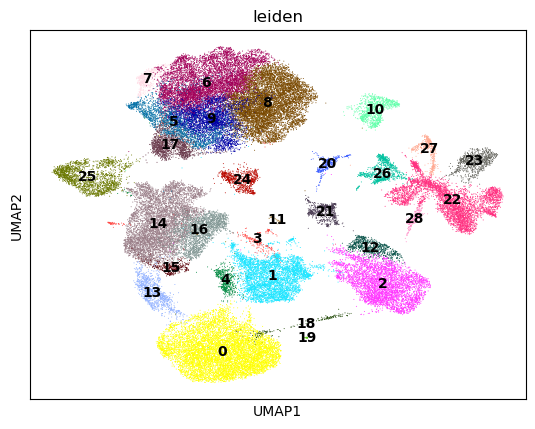

In [19]:
# visualize and label cell clusters
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.8)
sc.pl.umap(adata, color=["leiden"], legend_loc='on data')

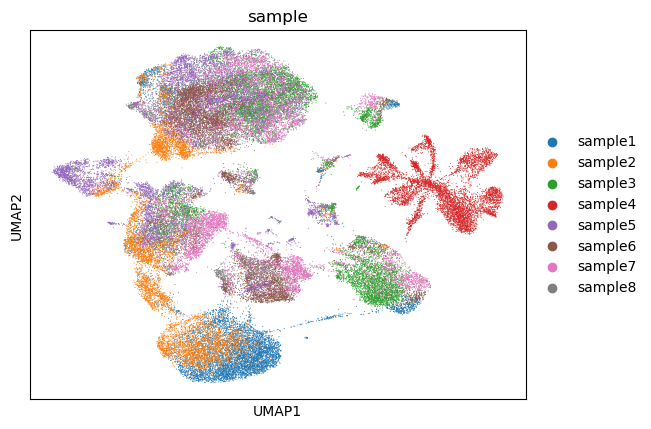

In [20]:
# visualize and label cell clusters by sample of origin
sc.pl.umap(
    adata,
    color="sample",
    size=2
)

# Integration

**Figures:**
1. Visualize clustering results of cells before and after integration, labels that identify samples cells originated from

**Discussion:**
1. Remark on plots and effects you observe due to integration
    *  The first plot are the clusters we observe before integration. Here we see that sample 4 was a distinct cluster. For our analysis, we want a homogenized clustering of the samples. Distinct sample clusters could indicate batch effects that we want need to handle. I used the BBKNN method to integrate the data since it is designed to remove batch effects. After integration, we observe – that while the cells in sample 4 are still group together – they have substantial overlap with cells from other samples as well. I also recreated the figure of the numbered clusters. Integration appeared to further reduce the number of clusters from 28 to 15.

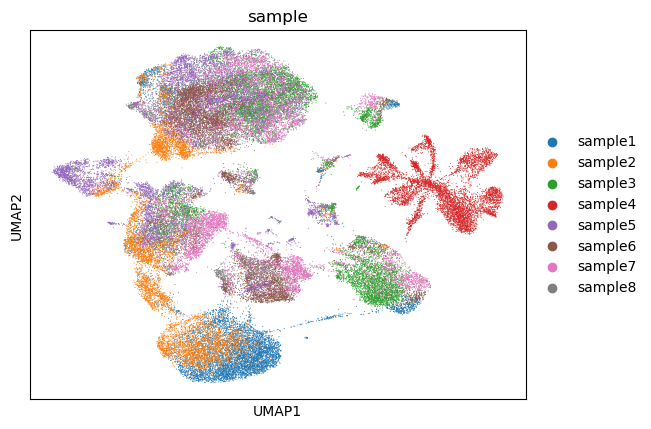

In [21]:
sc.pl.umap(
    adata,
    color="sample",
    size=2
)

In [22]:
pip install bbknn

Note: you may need to restart the kernel to use updated packages.


In [23]:
%%time
sc.external.pp.bbknn(adata, batch_key="sample")

CPU times: user 12.9 s, sys: 227 ms, total: 13.1 s
Wall time: 13.2 s


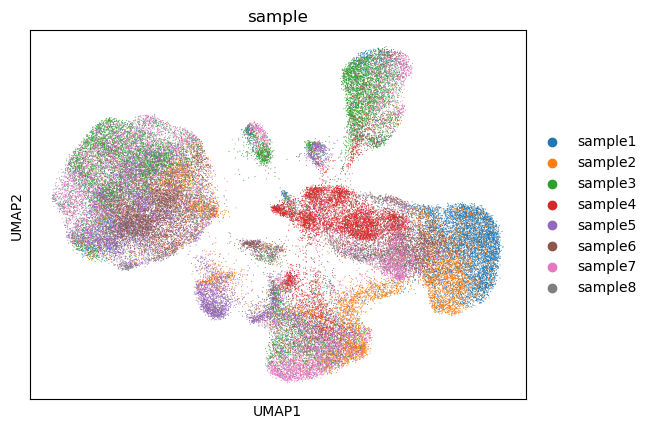

In [24]:
sc.tl.umap(adata)
sc.pl.umap(adata, size=2, color="sample")

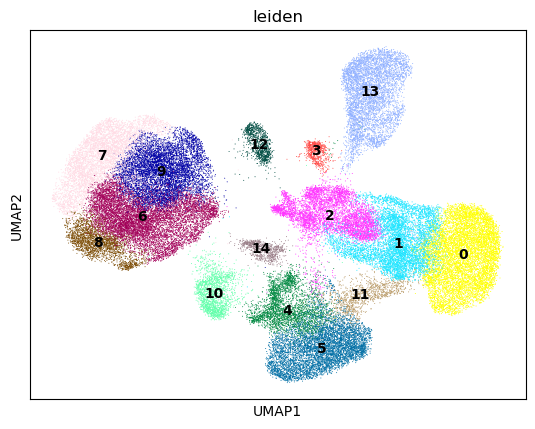

In [25]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.8)
sc.pl.umap(adata, color=["leiden"], legend_loc='on data')

# Marker Gene Analysis

**Figures:**
1. Table listing top five marker genes for each cluster

**Discussion:**
1. Describe method used to identify marker genes, discuss advantages and disadvantages of method
    * My first step was to user the Leiden algorithm to make cell clusters. This algorithm allows us to be less permissive with the cateogrization of cell clusters found in the data. I followed the paper's parameters and used a resolution of 0.8 to find a greater number of specifc cell clusters. I used these clusters to find the marker genes for each of the cell types. I used the Wilcoxon rank-sum test method to find these marker genes for each cluster since it is useful for data that is on a continuous scale (i.e., expression) and when that data is not normally distributed. scRNA-Seq data, such as ours, tends to follow a binomial distrubtion. Since Wilcoxon looks for differences amongst expression values, it has the tendency to ignore absolute differences between groups. This means that it looks for genes that are having large expression values, but can ignore biological differences between groups that might be observed in groups of genes that have consistent yet low expression values in specific clusters.

In [26]:
# rank genes using Leiden clusters and Wilcoxon method
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

In [27]:
# initialize list to hold top marker dfs for each cluster
top_markers_dfs = []

# get cluster labels 
cluster_names = adata.uns['rank_genes_groups']['names'].dtype.names

# loop through each cluster
for cluster in cluster_names:
    # extract marker genes for cluster
    df = sc.get.rank_genes_groups_df(adata, group=cluster)
    
    # grab the top 5 markers
    top_5 = df.head(5).copy()  # .copy() to avoid SettingWithCopyWarning
    
    # add column that indicates which cluster these marker genes represent
    top_5['cluster'] = cluster
    
    # add dataframe to list of dataframes
    top_markers_dfs.append(top_5)

# concatenate all dataframes into one
top5markers = pd.concat(top_markers_dfs, axis=0)

In [28]:
# show table of top 5 marker genes for each cluster
pd.set_option('display.max_rows', None)
print(top5markers)

      names      scores  logfoldchanges          pvals      pvals_adj cluster
0      TFF1  135.895401        5.891925   0.000000e+00   0.000000e+00       0
1      MUC1  135.809494        4.936536   0.000000e+00   0.000000e+00       0
2      AGR2  135.759903        5.093108   0.000000e+00   0.000000e+00       0
3      TFF3  135.001099        5.430393   0.000000e+00   0.000000e+00       0
4   STARD10  132.385391        4.143276   0.000000e+00   0.000000e+00       0
0  C19orf33   95.697174        3.421688   0.000000e+00   0.000000e+00       1
1    S100A6   91.898376        2.566411   0.000000e+00   0.000000e+00       1
2     KRT19   87.625374        3.157036   0.000000e+00   0.000000e+00       1
3    SPINT2   87.129570        2.953014   0.000000e+00   0.000000e+00       1
4      MAL2   84.686111        3.165730   0.000000e+00   0.000000e+00       1
0      IGKC  104.103470        6.587687   0.000000e+00   0.000000e+00       2
1     IGHA1  102.399521        6.122136   0.000000e+00   0.00000

# Automatic Annotation of Cell Labels

**Goals:** Assign preliminary labels for cell identities of clusters with your choice of tool

**Figures:**
1. Cell clustering with labels assigned be results of labeling tool

**Discussion:**
1. Discuss how algorithm works and ensure you cite original publication
    * To automatically annotate the cell clusters I used CellTypist. CellTypist is a machine learning based method that uses pretrained reference model that has labeled cell types ([Cross-tissue immune cell analysis reveals tissue-specific features in humans. Science 376, eabl5197 (2022)](https://www.science.org/doi/10.1126/science.abl5197)). This method implements a random forest classifier and uses majority voting to determine the best labels for the cell clusters. The user gets to choose which reference model they want to use to create predictions for their data. In this case I chose to use the Immune_All_High model since our investigation is into cancer metastasis, which involves the immune system. 
2. Comment on cell identities of your clusters and any speculation as to the original source tissue of samples based on what you see
    * Since I used the Immune_All_High reference model, it makes sense that my cell clusters link back to cell types associated with immunology. The biggest clusters appear to be: T cells, epithelial cells, macrophages, and fibroblasts. Macrophages are typical cells found in the role of cancer since they can act as promoters and suppresors of cancer development depending on how the cancer is hijacking the body. Epithelial cells are associated with the skin and the lining of internal organs. T cells play a large role in fighting cancer. Fibroblasts are involved in connective tissue and maintaining the extracellular matrix, which when cancer infects the body, these fibroblasts can be used to support tumor devopment by altering the extracellular matrix in the tissue. Based on these overarching themes, I would believe that these cell labels may indicate that this sample comes from tumor tissue associated with a specific organ since it involves cell types involved in organ lining and connective tissue.

In [29]:
adata_celltypist = adata.copy()
adata_celltypist.obs_names_make_unique()
adata_celltypist.var_names_make_unique()

In [30]:
predictions = celltypist.annotate(adata_celltypist, model = 'Immune_All_High.pkl', majority_voting = True)

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 60894 cells and 25870 genes
🔗 Matching reference genes in the model
🧬 5848 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [31]:
predictions.predicted_labels.head()

predicted_labels over_clustering   majority_voting
AAACCCAAGCTAATCC-1  Epithelial cells              76  Epithelial cells
AAACCCAAGGCTGTAG-1           T cells              75  Epithelial cells
AAACCCACAAACAGGC-1  Epithelial cells             108  Epithelial cells
AAACCCAGTACTCGAT-1  Epithelial cells             213  Epithelial cells
AAACCCAGTGCTGCAC-1  Epithelial cells              62  Epithelial cells

In [32]:
adata_celltypist.obs = adata_celltypist.obs.join(predictions.predicted_labels)

In [33]:
sc.tl.umap(adata_celltypist)

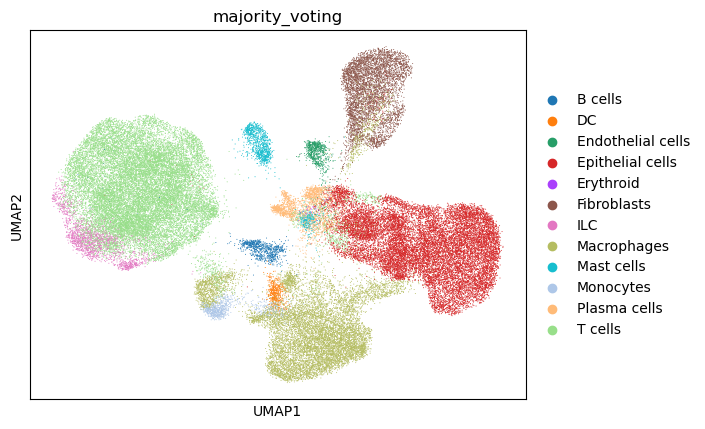

In [34]:
sc.pl.umap(adata_celltypist, color = ['majority_voting'], size = 2)

# Manual Cluster Labeling

**Goals:** Search through the literature using our marker gene analysis along with the automatic annotation algorithm to provide final determinations of the cell identities for each cluster.

**Figures:**
1. Plot that displays top marker genes for every cluster in dataset (dotplot)
2. For top three clusters with most cells, create individual plots of at least 5 of the defining marker genes for that cluster and their expression compared across all clusters
3. Plot of clusters with manual anotations and labels of cell identities

**Discussion:**
1. Paragraph describing cell annotations and explaining what cell label you have assigned to each cluster, including at least one citation to support your labeling and choice of marker genes for each cluster
    * To create my cell labels, I incorporated data from the automatic annotations and then researched cell types based on one or two cell markers for each of the top five clusters that had the greatest number of cells (Clusters 6, 0, 9, 1 and 5). For the cell types I didn't research, I used the automatic cell annotations by comparing the automatic cell annotations UMAP to the Leiden cluster UMAP. For each cluster I did research, I used the cell marker that had the greatest average cell expression and was most unique to that cluster. Meaning, that I tried to choose genes that only showed up in that cluster, or very few other clusters. For cluster 6, I used CCL5 and discovered that gene is a T Cell marker ([Seo et al. 2020](https://www.nature.com/articles/s41467-020-15375-w)). For cluster 0, I used both TFF1 and TFF3 and discovered those genes are markers for Goblet Cells, which are a specialized form of Epithelial Cells ([Langer et al. 1999](https://pubmed.ncbi.nlm.nih.gov/10476786/)). For cluster 9, I used IL7R as the marker and discovered it is associated with T Cells ([Colpitts et al. 2010](https://pmc.ncbi.nlm.nih.gov/articles/PMC2754146/)). For cluster 1, I used KRT19 as the marker and discovered it is associated with Epithelial cells ([Xu et al. 2024](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2024.1385867/full)). For cluster 5, I used C1QA since the other genes seemed to be present in neural cells, which isn't in the scope of our investigation, this marker seemed to be associated with Macrophages ([Horowitz et al. 2024](https://pmc.ncbi.nlm.nih.gov/articles/PMC10849641/#:~:text=(b)%20C1QA%20expression%20pattern%20in,GSE46903%20(n%20%3D%20384))).

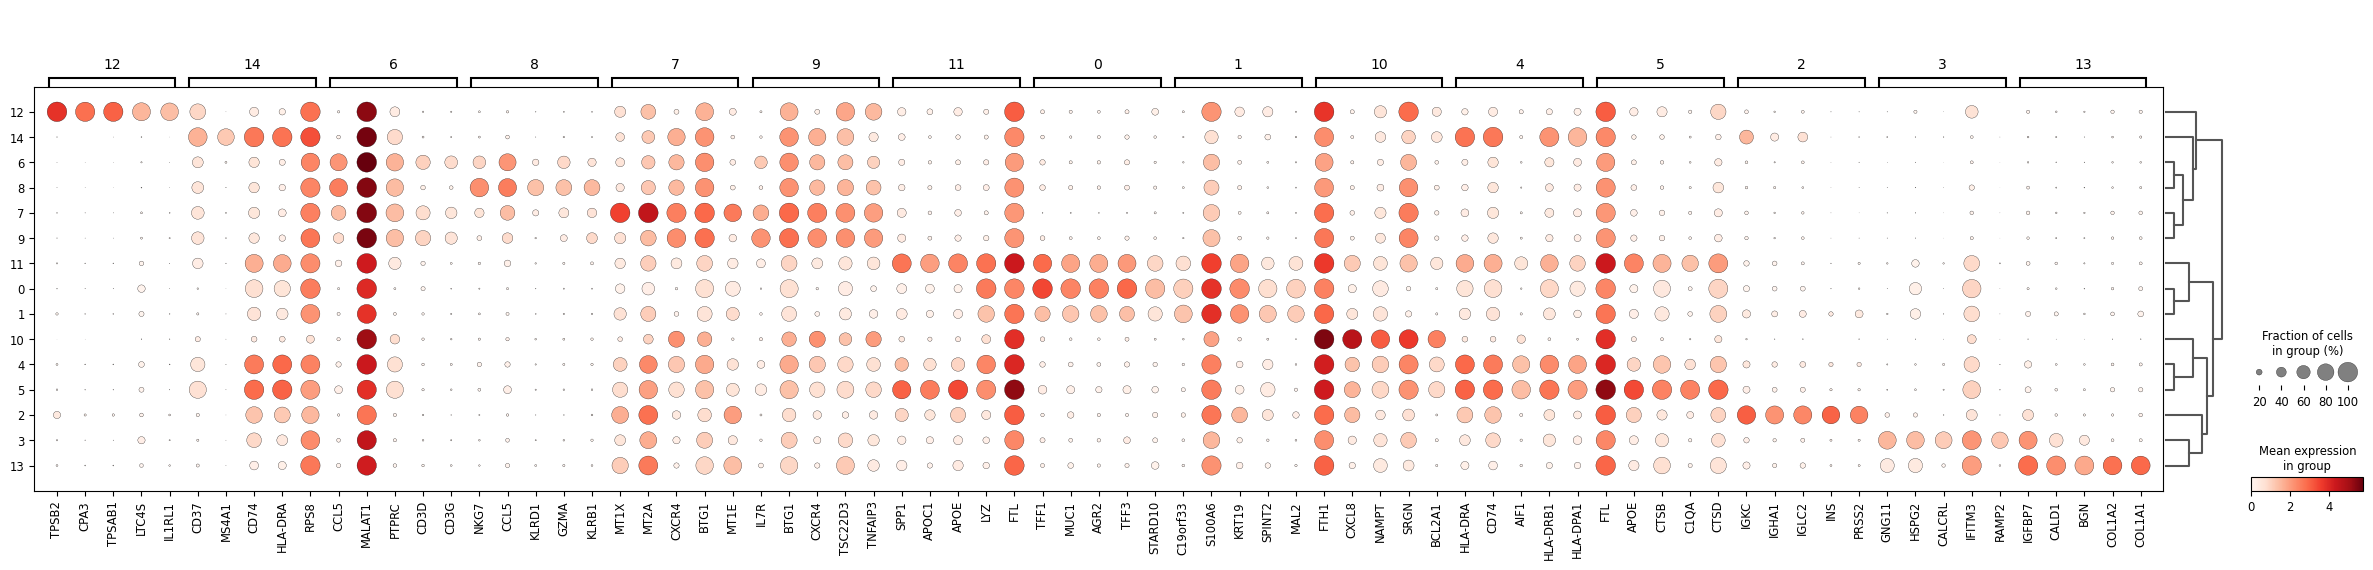

In [35]:
# create dotplot
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)

In [36]:
# find clusters with most cells
adata.obs['leiden'].value_counts()

leiden
6     8233
0     8073
9     6587
1     6091
5     5965
13    5276
2     5228
7     4744
4     3031
8     2259
10    1890
11    1136
12     966
14     766
3      649
Name: count, dtype: int64

In [37]:
top3_names = ['6','0','9']
adata_top3 = adata[adata.obs['leiden'].isin(top3_names)].copy()

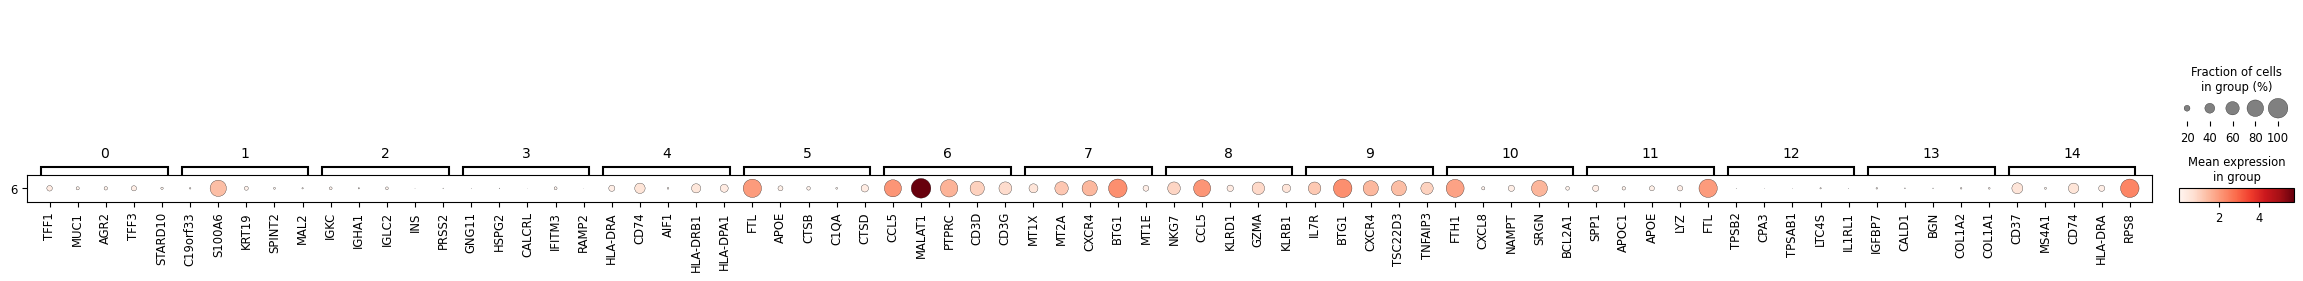

In [38]:
sc.pl.rank_genes_groups_dotplot(adata_top3[adata_top3.obs['leiden'] == '6'], n_genes=5)

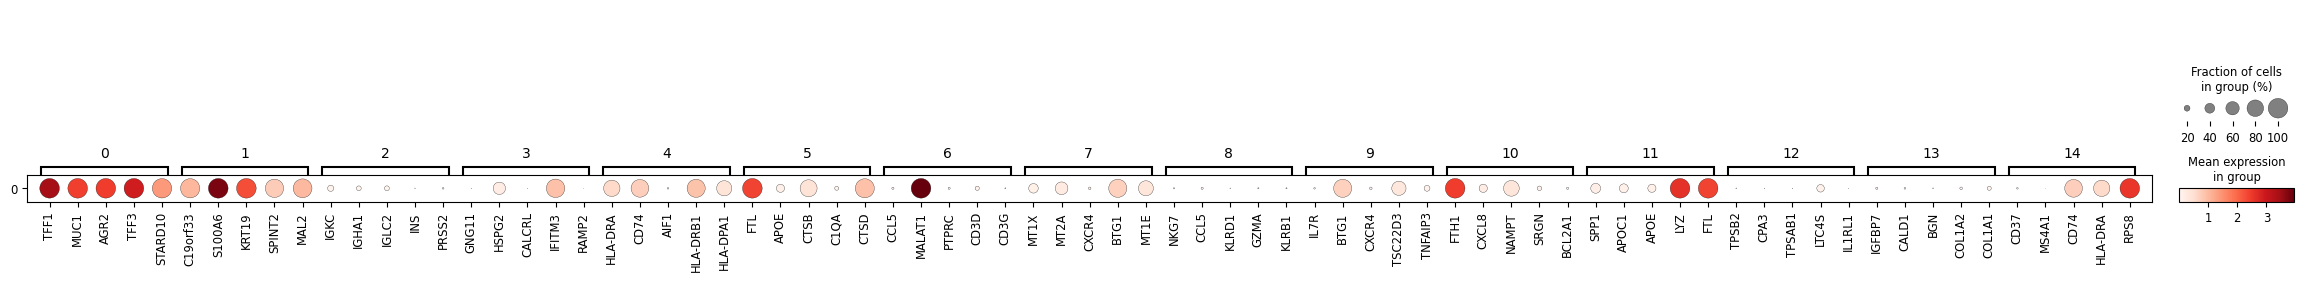

In [39]:
sc.pl.rank_genes_groups_dotplot(adata_top3[adata_top3.obs['leiden'] == '0'], n_genes=5)

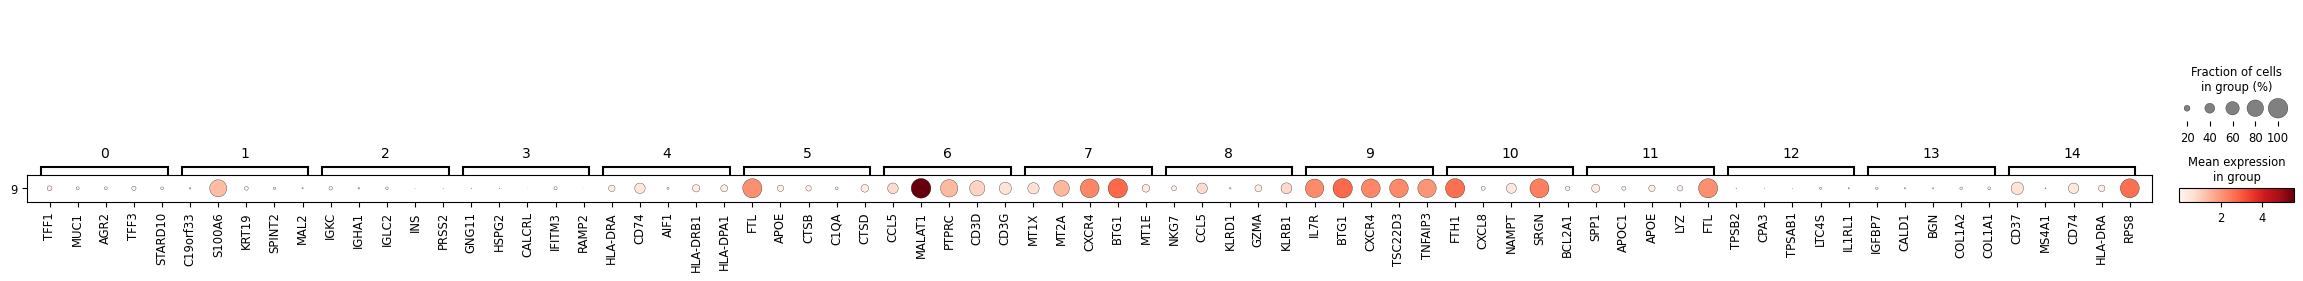

In [40]:
sc.pl.rank_genes_groups_dotplot(adata_top3[adata_top3.obs['leiden'] == '9'], n_genes=5)

In [41]:
# create dictionary of manual labels based on Leiden clusters
manual_labels = {
    '0' : "Goblet Cells",
    '1' : "Epithelial Cells",
    '2': "Plasma Cells",
    '3': "Endothelial Cells",
    '4': "Macrophages",
    '5': "Macrophages",
    '6': "T Cells",
    '7': "T Cells",
    '8': "Innate Lymphoid Cells",
    '9': "T Cells",
    '10': "Monocytes",
    '11': "Macrophages",
    '12': "Mast Cells",
    '13': "Fibroblasts",
    '14': "B Cells"
}

In [42]:
# map manual labels onto data
adata_celltypist.obs['manual'] = adata_celltypist.obs['leiden'].map(manual_labels)

... storing 'manual' as categorical


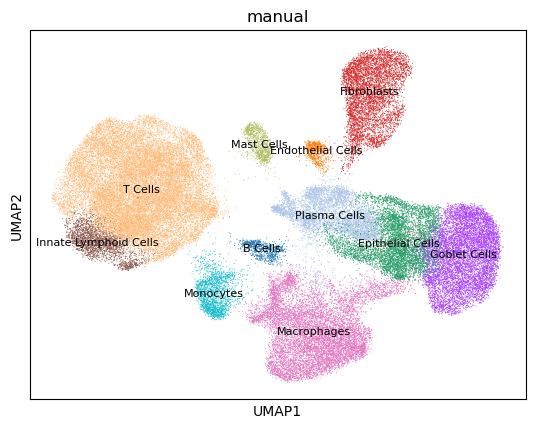

In [43]:
# visualize with manual labels
sc.pl.umap(adata_celltypist, color = ['manual'], size = 2, legend_loc="on data", legend_fontsize=8, legend_fontweight="normal")

# Further Analysis

This section was supposed to include recreations of two of the paper's major findings, either: Pseudotime Analysis, RNA Velocity, Cell Proportion analyis, or Cell Signaling Analysis. After trouble shooting for several hours, I wasn't able to recreate these analyses for two reasons. The first reason was that the researchers didn't include the data to be able to reproduce their Pseudotime Analysis or RNA Velocity. The second reason was that with the recommended packages to carry out additional analyses there were package dependencies that the SCC does not have installed. As an alternative, I tried to recreate a figure similar to 2F and 2G. Additionally, I calculated the proportions of each manually labeled cell type for each sample and tissue type the samples were collected from (primary pancreatic tumors (PT), hepatic metastases (HM), and normal pancreatic tissue (PT)). After that, I tried to calculate JSD scores and make a similar rendering of figure 1F.

**Figure 2F/G Recreation**

For this figure, I created a heatmap of the average gene expression for the top gene markers for the manual cell type labels across the different tissue sources. The main observation is that PTPRC appears to have significantly elevated expression levels in cancerous tissue samples compared to normal pancreatic tissue. PTPRC, otherwise known as CD45, has been shown to have an important impact in cancer development and is a typical drug target for cancer treatment. Our observation aligns with the results of other studies that have observed enhanced exprssion od CD45 in tumor samples ([Ye et al. 2022](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2022.928328/full)).


**Cell Type Proportions Across Samples and Tissue Types**

In this investigation I was interested in observing which cell types show up the most in each sample and each tissue. Case2ZC is our only sample from normal pancreatic tissue. In normal tissue we are likely to see less immune specific cells such as T Cells, B Cells, mast cells and monocytes since there is not an active immune attack on the body. In cancerous tissue, we observe a larger variety of immune cells that play critical roles in tumor microenvironments (TME). Across cancerous tissue samples, we see an increase in the proportion of macrophages, T Cells, and endothelial cells which are some of the main cellular components of TMEs ([Tie et al. 2022](https://jhoonline.biomedcentral.com/articles/10.1186/s13045-022-01282-8#:~:text=Innate%20immune%20cells%20such%20as,the%20tumor%20microenvironment%20(TME).)).


**JSD Analysis**

JSD allows us to understand differences between the two distributions of two different populations. In this context, I used JSD to understand the expression differences in the various cell types across the two cancerous tissue types. This calculation can allow us to quantify differences in the molecular composition of the two tissue samples ([Everaert et al. 2020](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-3407-z#:~:text=JSD%20Score%20%5B9%5D&text=The%20tissue%20specificity%20score%20is,genes%20from%20the%20background%20set.)). Overall, the JSD values were fairly low between the tissue types, with a greater divergence in PT than HM.  

### Figure 2F/G Recreation

In [44]:
# dicitonary mapping actual sample names to sample replicate identities
sample_names = {
    "sample1" : "CASE1YF",
    "sample2" : "CASE1ZY",
    "sample3" : "CASE2YF",
    "sample4" : "CASE2ZC",
    "sample5" : "CASE2ZY",
    "sample6" : "CASE3YF",
    "sample7" : "CASE3ZY",
    "sample8" : "CASE4ZY"
}

In [45]:
# dictionary mapping tissue origins to samples
sample_groups = {
    "CASE1YF" : "PT",
    "CASE1ZY" : "HM",
    "CASE2YF" : "PT",
    "CASE2ZC" : "NT",
    "CASE2ZY" : "HM",
    "CASE3YF" : "PT",
    "CASE3ZY" : "HM",
    "CASE4ZY" : "HM"
}

In [46]:
# map sample names and tissue types onto the observation data
adata_celltypist.obs['sample_names'] = adata_celltypist.obs['sample'].map(sample_names)
adata_celltypist.obs['sample_groups'] = adata_celltypist.obs['sample_names'].map(sample_groups)

In [47]:
adata_celltypist.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACCCAAGCTAATCC-1               4845                 8.485909       20821.0   
AAACCCAAGGCTGTAG-1               3575                 8.182000       12284.0   
AAACCCACAAACAGGC-1               1772                 7.480428        4832.0   
AAACCCAGTACTCGAT-1               3975                 8.288032       16395.0   
AAACCCAGTGCTGCAC-1               3634                 8.198364       13037.0   

                    log1p_total_counts  pct_counts_in_top_50_genes  \
AAACCCAAGCTAATCC-1            9.943766                   32.635320   
AAACCCAAGGCTGTAG-1            9.416134                   27.727125   
AAACCCACAAACAGGC-1            8.483223                   30.132450   
AAACCCAGTACTCGAT-1            9.704793                   30.186032   
AAACCCAGTGCTGCAC-1            9.475623                   28.710593   

                    pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
AAACCCAAGCTAATCC-1                    40.881802                    49.824696   
AAACCCAAGGCTGTAG-1                    37.577336                    48.632367   
AAACCCACAAACAGGC-1                    43.687914                    56.436258   
AAACCCAGTACTCGAT-1                    41.957914                    53.888381   
AAACCCAGTGCTGCAC-1                    39.786761                    51.024009   

                    pct_counts_in_top_500_genes  total_counts_mt  \
AAACCCAAGCTAATCC-1                    61.942270           3436.0   
AAACCCAAGGCTGTAG-1                    63.082058            700.0   
AAACCCACAAACAGGC-1                    71.750828            186.0   
AAACCCAGTACTCGAT-1                    66.813053           1615.0   
AAACCCAGTGCTGCAC-1                    64.539388           1075.0   

                    log1p_total_counts_mt  ...  doublet_score  \
AAACCCAAGCTAATCC-1               8.142354  ...       0.176301   
AAACCCAAGGCTGTAG-1               6.552508  ...       0.040038   
AAACCCACAAACAGGC-1               5.231109  ...       0.328283   
AAACCCAGTACTCGAT-1               7.387709  ...       0.031746   
AAACCCAGTGCTGCAC-1               6.981006  ...       0.017869   

                    predicted_doublet   sample  leiden  predicted_labels  \
AAACCCAAGCTAATCC-1              False  sample1       0  Epithelial cells   
AAACCCAAGGCTGTAG-1              False  sample1       0           T cells   
AAACCCACAAACAGGC-1              False  sample1       2  Epithelial cells   
AAACCCAGTACTCGAT-1              False  sample1       0  Epithelial cells   
AAACCCAGTGCTGCAC-1              False  sample1       0  Epithelial cells   

                    over_clustering   majority_voting        manual  \
AAACCCAAGCTAATCC-1               76  Epithelial cells  Goblet Cells   
AAACCCAAGGCTGTAG-1               75  Epithelial cells  Goblet Cells   
AAACCCACAAACAGGC-1              108  Epithelial cells  Plasma Cells   
AAACCCAGTACTCGAT-1              213  Epithelial cells  Goblet Cells   
AAACCCAGTGCTGCAC-1               62  Epithelial cells  Goblet Cells   

                    sample_names  sample_groups  
AAACCCAAGCTAATCC-1       CASE1YF             PT  
AAACCCAAGGCTGTAG-1       CASE1YF             PT  
AAACCCACAAACAGGC-1       CASE1YF             PT  
AAACCCAGTACTCGAT-1       CASE1YF             PT  
AAACCCAGTGCTGCAC-1       CASE1YF             PT  

[5 rows x 28 columns]

In [48]:
# extract list of top5markers for each cluster
marker_genes = top5markers['names'].tolist()

# instantiate expression matrix with sample group (columns) and marker gene (rows) labels
expr_matrix = pd.DataFrame(
    columns=adata_celltypist.obs['sample_groups'].unique(),
    index=marker_genes
)

In [49]:
# add average expression values to matrix
for group in expr_matrix.columns:
    group_mask = adata_celltypist.obs['sample_groups'] == group
    group_means = np.array(adata_celltypist[group_mask, marker_genes].X.mean(axis=0)).flatten()
    expr_matrix[group] = group_means

In [50]:
# map genes for each cluster onto the matrix to get the clusters
gene_to_cluster = top5markers.set_index('names')['cluster'].to_dict()
expr_matrix['leiden'] = expr_matrix.index.map(gene_to_cluster)
# map manual cell labels onto the clusters
expr_matrix['cells'] = expr_matrix['leiden'].map(manual_labels)
# reset index to allow the genes to be a column
expr_matrix = expr_matrix.reset_index()
# rename column
expr_matrix.rename(columns={"index": "gene"}, inplace=True)

In [55]:
expr_matrix.head(15)

gene        PT        HM        NT leiden             cells
0       TFF1  0.934727  0.829021  0.212076      0      Goblet Cells
1       MUC1  0.673725  0.512330  0.389904      0      Goblet Cells
2       AGR2  0.732537  0.478116  0.188773      0      Goblet Cells
3       TFF3  0.910009  0.568599  0.141552      0      Goblet Cells
4    STARD10  0.399791  0.285614  0.153858      0      Goblet Cells
5   C19orf33  0.318430  0.310597  0.345247      1  Epithelial Cells
6     S100A6  2.196421  2.271431  3.061669      1  Epithelial Cells
7      KRT19  0.715776  0.626178  1.754007      1  Epithelial Cells
8     SPINT2  0.363668  0.299812  0.551749      1  Epithelial Cells
9       MAL2  0.355712  0.246315  0.259628      1  Epithelial Cells
10      IGKC  0.146011  0.101022  3.100226      2      Plasma Cells
11     IGHA1  0.067331  0.039209  2.191011      2      Plasma Cells
12     IGLC2  0.118611  0.043537  2.390383      2      Plasma Cells
13       INS  0.005352  0.000000  3.310904      2      Plasma Cells
14     PRSS2  0.035995  0.016204  2.587812      2      Plasma Cells

In [56]:
# set up data for heatmap
heatmap_data = expr_matrix.set_index("gene")[["PT", "HM", "NT"]]

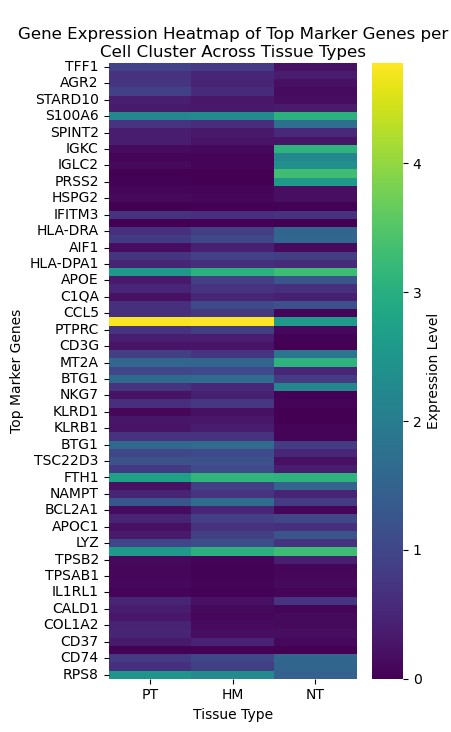

In [57]:
# create heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(
    heatmap_data,
    cmap="viridis",  # Or "coolwarm", "magma", etc.
    cbar_kws={'label': 'Expression Level'}
)
plt.title("Gene Expression Heatmap of Top Marker Genes per Cell Cluster Across Tissue Types", wrap=True)
plt.xlabel("Tissue Type")
plt.ylabel("Top Marker Genes")
plt.show()

### Cell Type Proportions Across Samples and Tissue Types

In [58]:
# grab cell counts
cell_counts = adata_celltypist.obs.groupby(['sample_names', 'sample_groups'])['manual'].value_counts().unstack(fill_value=0)
cell_counts = cell_counts.reset_index()
cell_counts.columns.name = None

In [61]:
# calculate proportions
props = cell_counts.iloc[:, 2:]
col_props = props.div(props.sum(axis=0), axis=1)
cols = pd.concat([cell_counts.iloc[:,0:2], col_props], axis=1)
df = cols.loc[~(cols.select_dtypes(include='number') == 0).all(axis=1)]

In [72]:
df

sample_names sample_groups   B Cells  Endothelial Cells  Epithelial Cells  \
2       CASE1YF            PT  0.005222           0.049307          0.124118   
3       CASE1ZY            HM  0.086162           0.123267          0.073059   
8       CASE2YF            PT  0.169713           0.215716          0.017403   
10      CASE2ZC            NT  0.001305           0.052388          0.133804   
12      CASE2ZY            HM  0.203655           0.520801          0.065835   
17      CASE3YF            PT  0.382507           0.013867          0.306682   
18      CASE3ZY            HM  0.066580           0.016949          0.207848   
21      CASE4ZY            HM  0.084856           0.007704          0.071253   

    Fibroblasts  Goblet Cells  Innate Lymphoid Cells  Macrophages  Mast Cells  \
2      0.097991      0.650687               0.158477     0.047079    0.149068   
3      0.014405      0.287254               0.086321     0.285136    0.015528   
8      0.572403      0.000372               0.142098     0.138670    0.503106   
10     0.042835      0.000000               0.000443     0.074319    0.006211   
12     0.013078      0.003221               0.401948     0.168476    0.002070   
17     0.102540      0.046080               0.036299     0.074418    0.091097   
18     0.156558      0.012139               0.114210     0.201145    0.232919   
21     0.000190      0.000248               0.060204     0.010758    0.000000   

    Monocytes  Plasma Cells   T Cells  
2    0.001587      0.014537  0.027602  
3    0.184656      0.009564  0.102893  
8    0.009524      0.024675  0.285729  
10   0.000000      0.872609  0.000000  
12   0.690476      0.025822  0.207166  
17   0.020635      0.021232  0.205428  
18   0.048677      0.021614  0.144705  
21   0.044444      0.009946  0.026477

In [75]:
# set up data for bar plot
df_plot = df.set_index('sample_names')
groups = df_plot.pop('sample_groups')

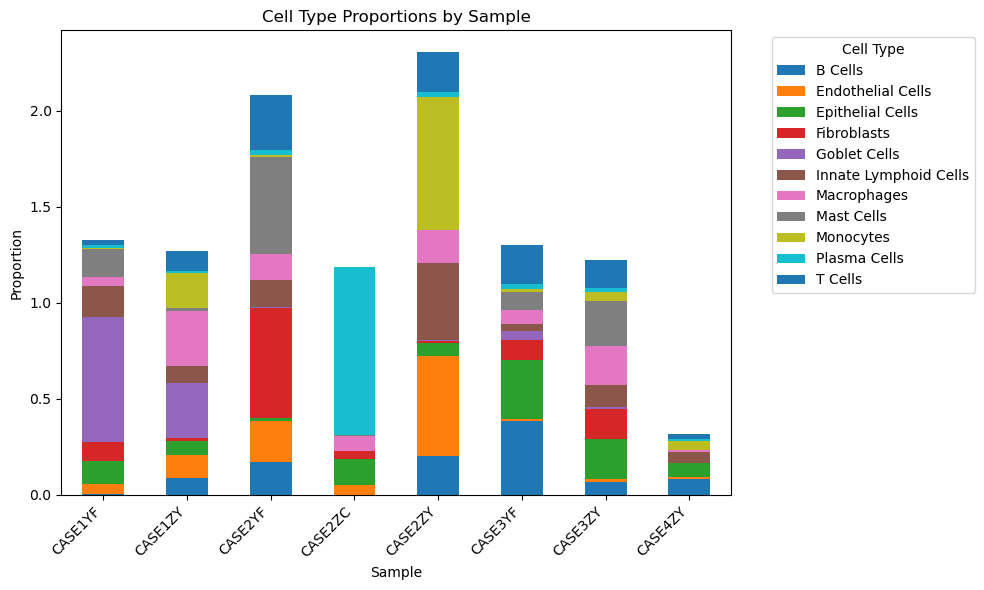

In [78]:
# create bar plot
df_plot.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.ylabel('Proportion')
plt.xlabel('Sample')
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Proportions by Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [81]:
df_groups = df.set_index('sample_groups')
names = df_groups.pop('sample_names')
df_grouped = df_groups.groupby(df_groups.index).sum()

In [82]:
df_grouped

B Cells  Endothelial Cells  Epithelial Cells  Fibroblasts  \
sample_groups                                                               
HM             0.441253           0.668721          0.417994     0.184230   
NT             0.001305           0.052388          0.133804     0.042835   
PT             0.557441           0.278891          0.448202     0.772934   

               Goblet Cells  Innate Lymphoid Cells  Macrophages  Mast Cells  \
sample_groups                                                                 
HM                 0.302861               0.662683     0.665515    0.250518   
NT                 0.000000               0.000443     0.074319    0.006211   
PT                 0.697139               0.336875     0.260166    0.743271   

               Monocytes  Plasma Cells   T Cells  
sample_groups                                     
HM              0.968254      0.066947  0.481241  
NT              0.000000      0.872609  0.000000  
PT              0.031746      0.060444  0.518759

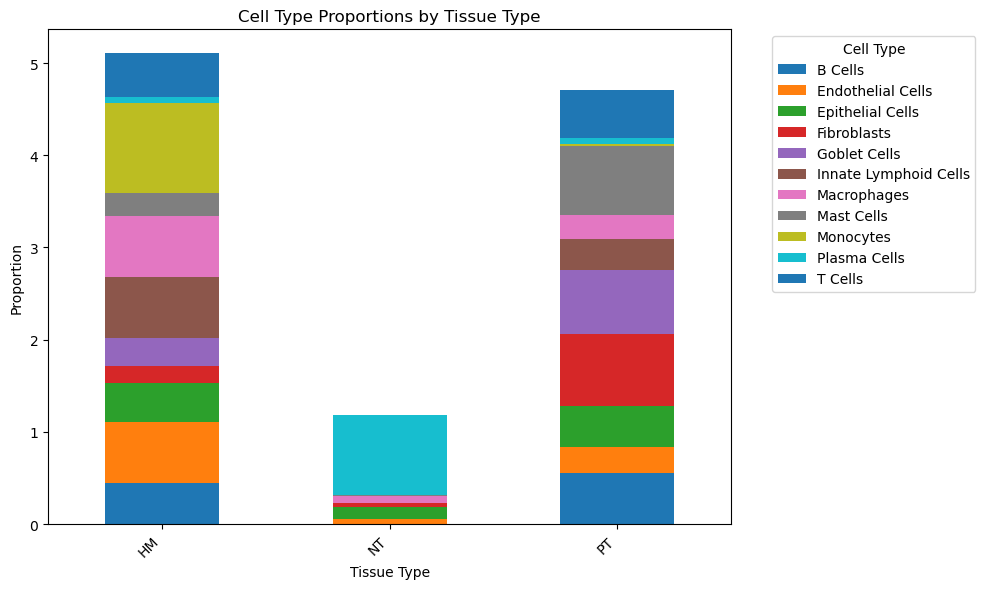

In [84]:

df_grouped.plot(kind='bar', stacked=True, figsize=(10, 6))

# Step 3: Customize
plt.ylabel('Proportion')
plt.xlabel('Tissue Type')
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Proportions by Tissue Type')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### JSD

In [85]:
# define JSD function
def compute_jsd(p, q):
    # Normalize distributions to sum to 1
    p = p / np.sum(p)
    q = q / np.sum(q)
    return jensenshannon(p, q, base=2)  # base=2 gives values between 0 and 1

# create expression values df
expr_df = pd.DataFrame(adata_celltypist.X.toarray(), index=adata_celltypist.obs_names, columns=adata_celltypist.var_names)

# cell type labels
expr_df['manual'] = adata_celltypist.obs['manual'].values

expr_df['sample_groups'] = adata_celltypist.obs['sample_groups'].values

# mean expression per gene per cell type
mean_expr_by_type = expr_df.groupby(['sample_groups','manual']).mean()

# global average across all cells
global_mean_expr = expr_df.drop(columns=['manual', 'sample_groups']).mean()

# JSD between each cell type and the global mean
jsd_values = mean_expr_by_type.apply(lambda row: compute_jsd(row.values, global_mean_expr.values), axis=1)



In [86]:
# set up data
jsd_results = pd.DataFrame(jsd_values)
jsd_results.columns = ['JSD']
jsd_df = jsd_results.reset_index()
jsd_df = jsd_df[jsd_df['sample_groups'] != 'NT']

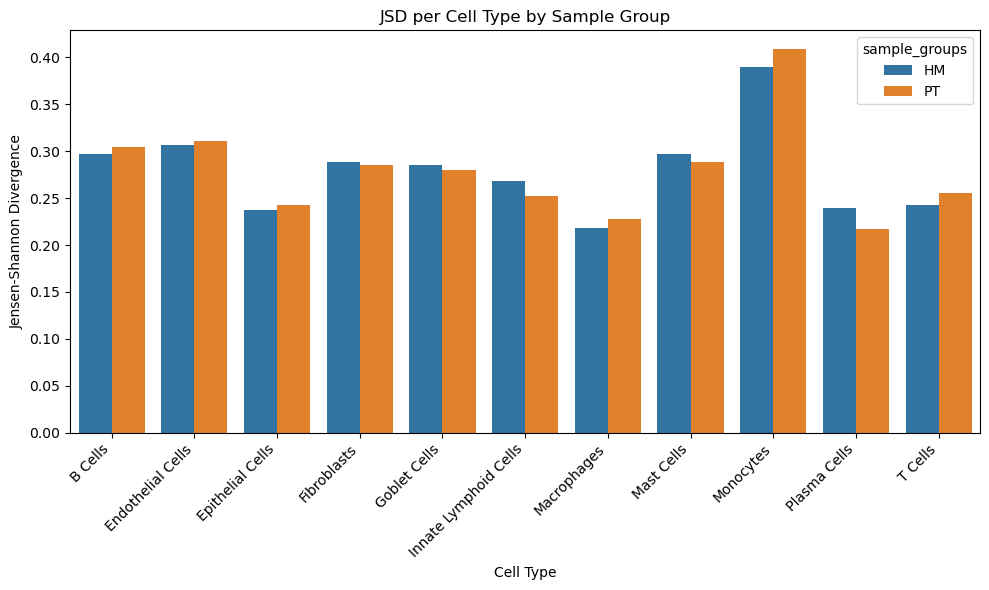

In [87]:
# create figure
plt.figure(figsize=(10, 6))
sns.barplot(data=jsd_df, x='manual', y='JSD', hue='sample_groups')

plt.xticks(rotation=45, ha='right')
plt.ylabel("Jensen-Shannon Divergence")
plt.xlabel("Cell Type")
plt.title("JSD per Cell Type by Sample Group")
plt.tight_layout()
plt.show()